# Discharge Notes and Readmission Rates: NLP

This notebook is for the processing the cleaned dataset through a NLP.

## Import

Import the relevant libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xg
from sklearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.utils import class_weight

## Functions

In [2]:
def scores(model, X, y, set_type):
    '''
    This function takes in an already fitted model, X, y, and
    the type of data (train, validation, or test) in str format,
    and prints out the accuracy and recall scores. The function
    also prints out the confusion matrix
    '''
    pred = model.predict(X)
    acc_score = accuracy_score(y, pred)
    rec_score = recall_score(y, pred)
    
    print("{} Scores".format(set_type))
    print("accuracy: ", acc_score)
    print("recall:   ", rec_score)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title(set_type)
    plot_confusion_matrix(model, X, y, ax=ax)
    return round(acc_score*100,1), round(rec_score*100,1) 

## Reading in the Data

Here, I read in the cleand dataset from the previous EDA folder.

In [3]:
df = pd.read_csv('data/admissions_cleaned_2.csv.gz', compression='gzip')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52726 entries, 0 to 52725
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      52726 non-null  object
 1   ADMISSION_LOCATION  52726 non-null  object
 2   DISCHARGE_LOCATION  52726 non-null  object
 3   INSURANCE           52726 non-null  object
 4   LANGUAGE            52726 non-null  object
 5   RELIGION            52726 non-null  object
 6   MARITAL_STATUS      52726 non-null  object
 7   ETHNICITY           52726 non-null  object
 8   DIAGNOSIS           52726 non-null  object
 9   READMISSION         52726 non-null  int64 
 10  GENDER              52726 non-null  object
 11  AGE                 52726 non-null  int64 
 12  TEXT                52726 non-null  object
 13  CPT_CD              52726 non-null  object
 14  DIAG_ICD9_CODE      52722 non-null  object
 15  DRG_CODE            52726 non-null  object
 16  PROCED_ICD9_CODE    52

In [5]:
df['READMISSION'].value_counts()

0    49715
1     3011
Name: READMISSION, dtype: int64

In [6]:
#set X as the text data, and y as the readmission status
X = df['TEXT']
y = df['READMISSION']

The dataset is heavily imbalanced, with a lot more negative cases. In order to handle class imbalance, I will later on use two method, SMOTE and undersampling, to mitigate the class imbalance.

## Train, Validation, and Test Split

I split the data set into three sets: Train, Validation, and Test.
The ratio I used was 70:15:15.

In [7]:
X_train, X_v_t, y_train, y_v_t = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [8]:
X_val, X_test, y_val, y_test = train_test_split(X_v_t, y_v_t, test_size=0.50, random_state=42, stratify=y_v_t)

In [9]:
X_train.shape

(36908,)

## Pipeline Parameters

In this section, I set specific pipeline parameters that I will keep constant throughout the project.

In [10]:
sw = stopwords.words('english')

#setting the number of maximum features as 10% of rows in X
max_feats = int(X_train.shape[0]*0.10)

## Modeling

In this section, I will run several different models. Once I decide the best model, I will export the results out so that in another notebook, I can merge that results to other data features and run that through models again to see if I can get a better model.

### Model 0: Dummy Classification

For my Model 0, I run a simple dummy classifier. I test out both a count vectorizer and a tfidf vectorizer to see if it will impact the results. I have yet to do anything about the class imbalance.

* Model: Dummy
* Vectorizer: Count
* Class Imbalance Solution: None

In [11]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified"))
    ])

Train Scores
accuracy:  0.8931938875040641
recall:    0.05218216318785579
Validation Scores
accuracy:  0.8908838032621065
recall:    0.046460176991150445
Test Scores
accuracy:  0.8940447591351625
recall:    0.06208425720620843


(89.4, 6.2)

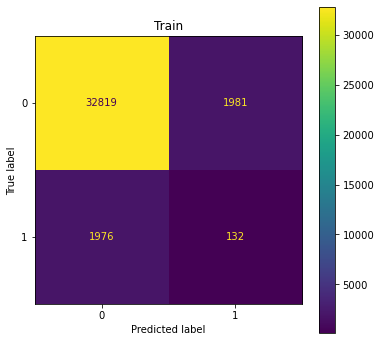

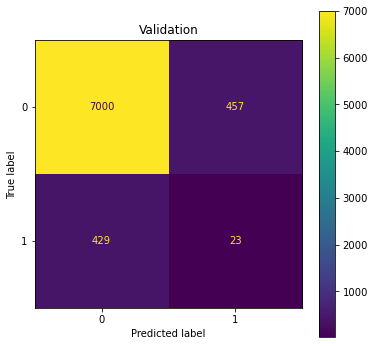

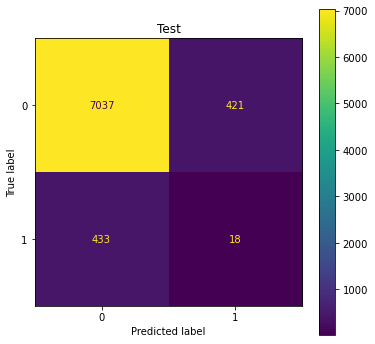

In [12]:
pp_count.fit(X_train, y_train)

scores(pp_count, X_train, y_train, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Dummy
* Vectorizer: Tfidf
* Class Imbalance Solution: None

In [13]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified")),   
    ])

Train Scores
accuracy:  0.8934377370759727
recall:    0.06072106261859583
Validation Scores
accuracy:  0.8910102414970287
recall:    0.0420353982300885
Test Scores
accuracy:  0.8916424326716399
recall:    0.06430155210643015


(89.2, 6.4)

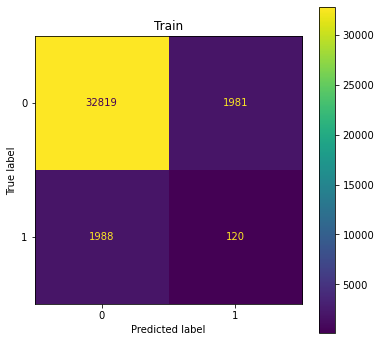

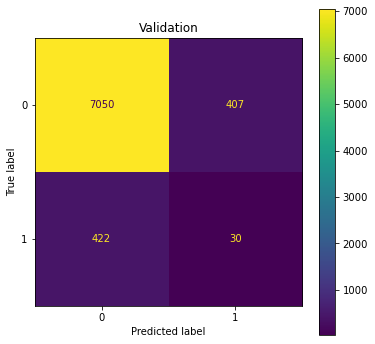

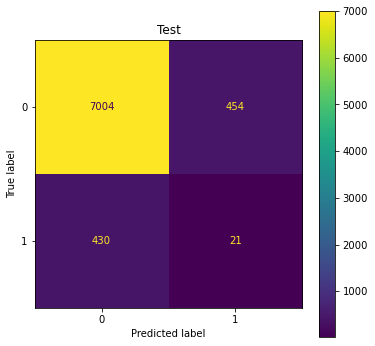

In [14]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

Though the accuracy is high for both the vectorizers through the dummy classifier model, the recall score was very poor. This is most likely due to the class imbalance. However, I will run a non-dummy, but simple logistic regression model to validate that the low recall score is not because of the dummy model itself.

### Model 1: Logistic Regression

The next model I decided to use is the logitic regression model.

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: None

In [ ]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

In [ ]:
pp_count.fit(X_train, y_train)

scores(pp_count, X_train, y_train, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: None

In [ ]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

In [ ]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

Again, the accuracy scores are high, but the recall scores are poor. Thus, for the next modeling step, I will try to improve the model by first trying to mitigate the class imbalance.

### Handling Imbalanced Data 

As mentioned before, the dataset is heavily imbalanced. I will implement three methods to handle the class imbalance:
* Undersample the negative cases
* Pass in class weights
* Implement SMOTE

#### Undersampling Negative Cases: 1 to 1

In [ ]:
#concat the train dataset together
train_df = pd.concat([y_train, X_train], axis=1)

In [ ]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [ ]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=len(train_df_pos), random_state=42)

In [ ]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [ ]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [ ]:
#split out the X and y of the new dataset
y_train_1 = new_train_df['READMISSION']
X_train_1 = new_train_df['TEXT']
max_feats_1 = int(X_train_1.shape[0]*0.10)

#### Undersampling Negative Cases: 2 to 1

In [ ]:
#concat the train dataset together
train_df = pd.concat([y_train, X_train], axis=1)

In [ ]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [ ]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=2*len(train_df_pos), random_state=42)

In [ ]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [ ]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [ ]:
#split out the X and y of the new dataset
y_train_2 = new_train_df['READMISSION']
X_train_2 = new_train_df['TEXT']
max_feats_2 = int(X_train_2.shape[0]*0.10)

#### Undersampling Negative Cases: 3 to 1

In [ ]:
#concat the train dataset together
train_df = pd.concat([y_train, X_train], axis=1)

In [ ]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [ ]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=2*len(train_df_pos), random_state=42)

In [ ]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [ ]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [ ]:
#split out the X and y of the new dataset
y_train_3 = new_train_df['READMISSION']
X_train_3 = new_train_df['TEXT']
max_feats_3 = int(X_train_3.shape[0]*0.10)

#### Class Weights

In [ ]:
#calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=[0,1],y=y_train)

In [ ]:
class_weights

### Model 1.1: Logistic Regression - Undersampling

In this section, I applied the undersampled dataset to logistic regression model.

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: Undersampling Negative 1:1

In [39]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7118121442125237
recall:    0.6902277039848197
Validation Scores
accuracy:  0.6610190921734732
recall:    0.5995575221238938
Test Scores
accuracy:  0.66986976861803
recall:    0.6208425720620843


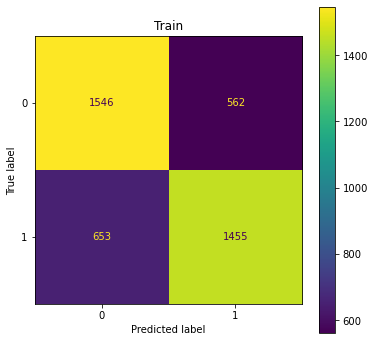

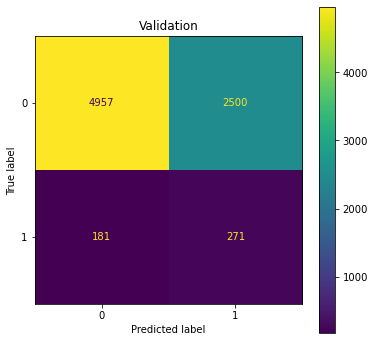

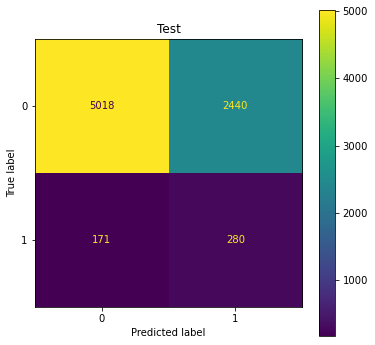

In [40]:
pp_count.fit(X_train_1, y_train_1)

scores(pp_count, X_train_1, y_train_1, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
log_acc, log_recall = scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Undersampling Negative 1:1

In [41]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.6954459203036053
recall:    0.6987666034155597
Validation Scores
accuracy:  0.6521684157289164
recall:    0.6438053097345132
Test Scores
accuracy:  0.6603869009988621
recall:    0.6430155210643016


(66.0, 64.3)

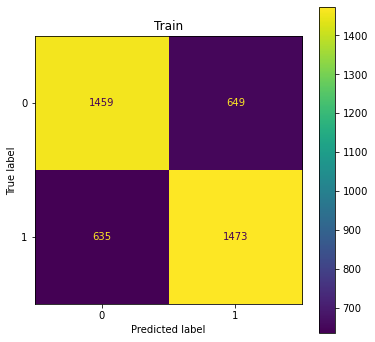

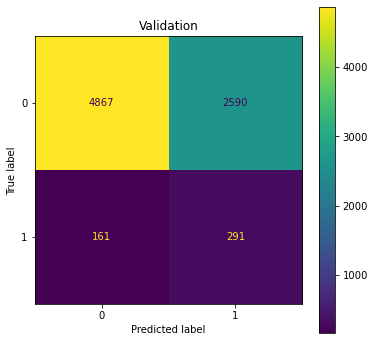

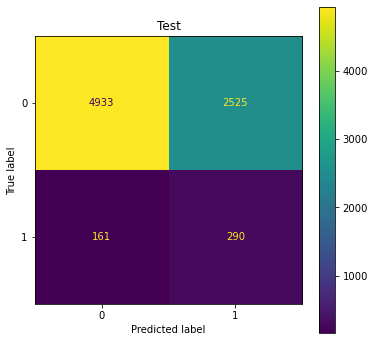

In [42]:
pp_tfidf.fit(X_train_1, y_train_1)

scores(pp_tfidf, X_train_1, y_train_1, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: Undersampling Negative 2:1

In [43]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats_2)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7583807716635041
recall:    0.5033206831119544
Validation Scores
accuracy:  0.796560880010115
recall:    0.3805309734513274
Test Scores
accuracy:  0.8023770388165381
recall:    0.42572062084257206


(80.2, 42.6)

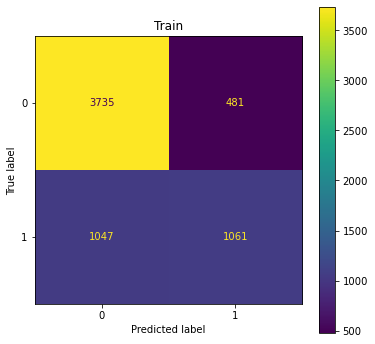

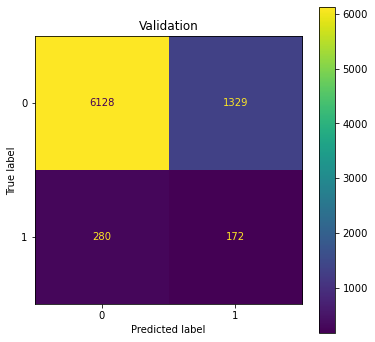

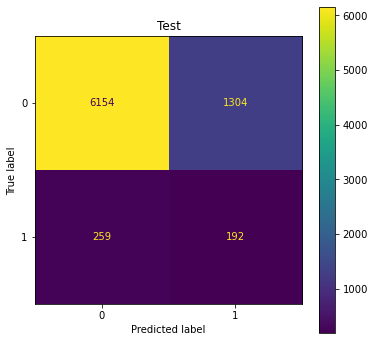

In [44]:
pp_count.fit(X_train_2, y_train_2)

scores(pp_count, X_train_2, y_train_2, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Undersampling Negative 2:1

In [45]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_2)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.7338709677419355
recall:    0.3894686907020873
Validation Scores
accuracy:  0.8511821974965229
recall:    0.3141592920353982
Test Scores
accuracy:  0.8534580857251233
recall:    0.35476718403547675


(85.3, 35.5)

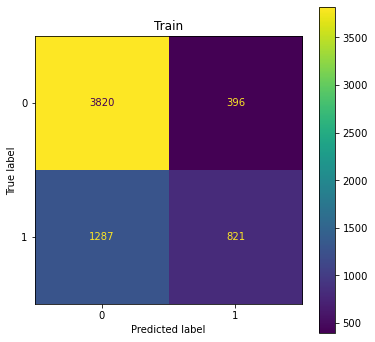

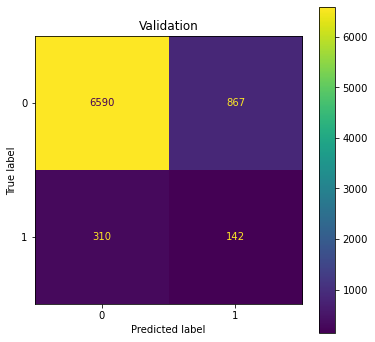

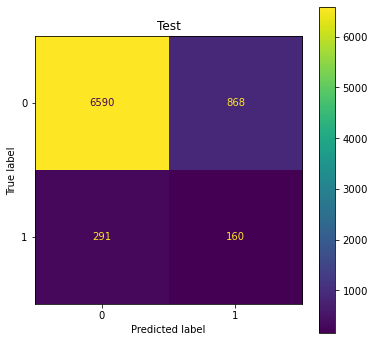

In [46]:
pp_tfidf.fit(X_train_2, y_train_2)

scores(pp_tfidf, X_train_2, y_train_2, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: Undersampling Negative 3:1

In [47]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats_3)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7583807716635041
recall:    0.5033206831119544
Validation Scores
accuracy:  0.796560880010115
recall:    0.3805309734513274
Test Scores
accuracy:  0.8023770388165381
recall:    0.42572062084257206


(80.2, 42.6)

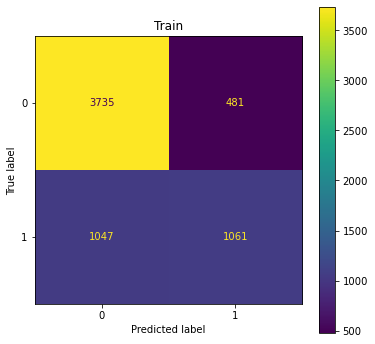

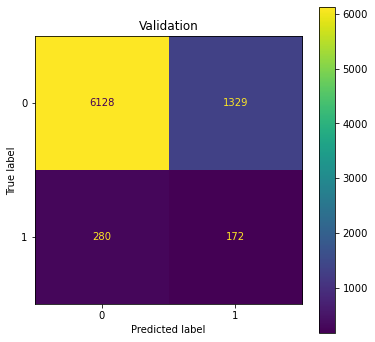

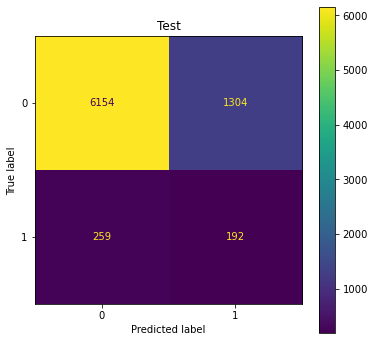

In [48]:
pp_count.fit(X_train_3, y_train_3)

scores(pp_count, X_train_3, y_train_3, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Undersampling Negative 3:1

In [49]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_3)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.7338709677419355
recall:    0.3894686907020873
Validation Scores
accuracy:  0.8511821974965229
recall:    0.3141592920353982
Test Scores
accuracy:  0.8534580857251233
recall:    0.35476718403547675


(85.3, 35.5)

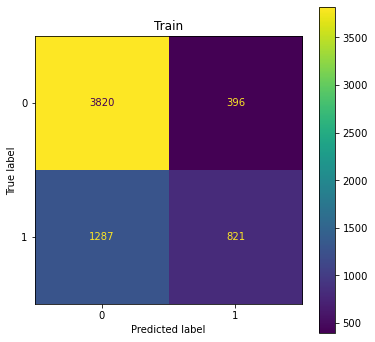

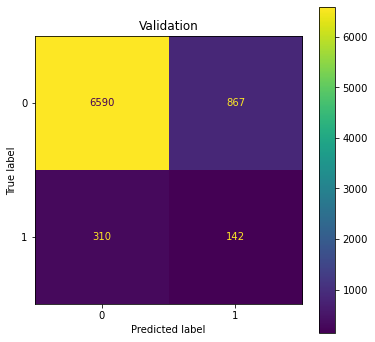

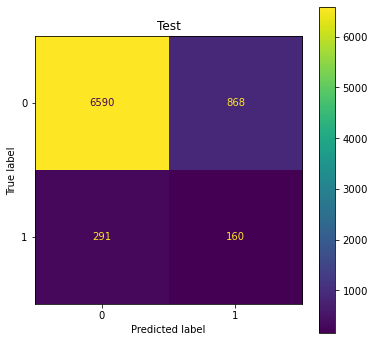

In [50]:
pp_tfidf.fit(X_train_3, y_train_3)

scores(pp_tfidf, X_train_3, y_train_3, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

After using the undersampled dataset, though the accuracy went down, the recall score went up. The ratio of 1 to 1 of negative to positive cases had the best recall scores. In addition, the tfidf vectorizer performed better than the count vectorizer, and so we will just use the tfidf vectorizer.

### Model 1.2: Logistic Regression - Class Weights

In this section, I passed in the class weights in the logistic regression model.

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Class Weights

In [51]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('logreg', LogisticRegression(random_state=42, class_weight=class_weights)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:680: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":


Train Scores
accuracy:  0.9432372385390702
recall:    0.006641366223908918
Validation Scores
accuracy:  0.943229232519914
recall:    0.00663716814159292
Test Scores
accuracy:  0.943229232519914
recall:    0.004434589800443459


(94.3, 0.4)

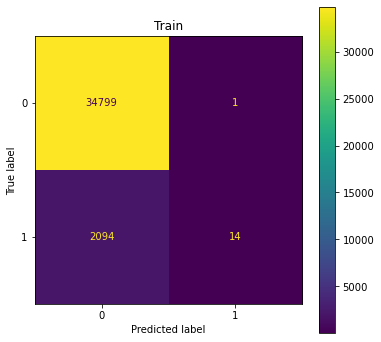

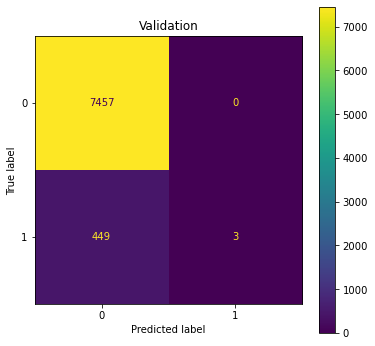

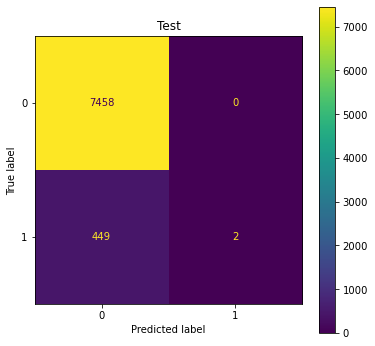

In [52]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

As seen above, passing in the class weights did not improve the recall score.

### Model 1.3: Logistic Regression - SMOTE

In this section, I utilized SMOTE to oversample the imbalanced class.

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: SMOTE

In [53]:
pp_tfidf = imbpipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42))   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.8120461688522813
recall:    0.7722960151802657
Validation Scores
accuracy:  0.7825262359337464
recall:    0.5
Test Scores
accuracy:  0.7820204829940574
recall:    0.4878048780487805


(78.2, 48.8)

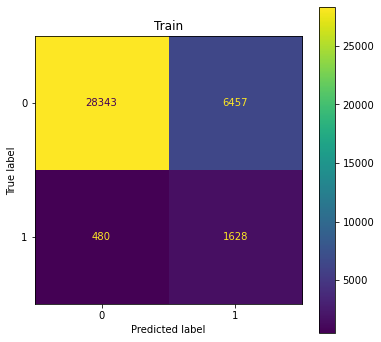

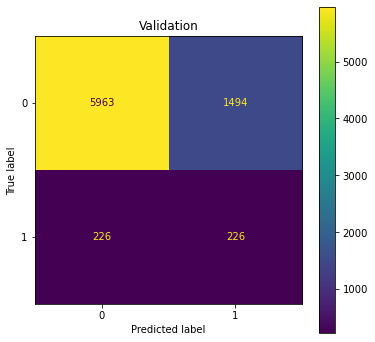

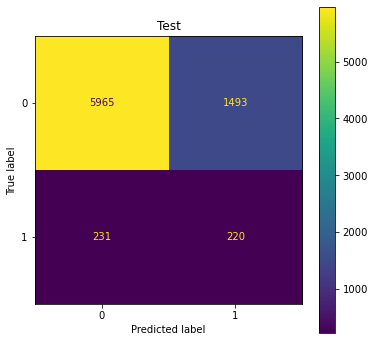

In [54]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

SMOTE did improve the recall score. However, running SMOTE into grid search will take too much computation power. In addition, it led to the model overfitting. Therefore, I will not utilize SMOTE.

### Introducing N-Grams

I wanted to test if introducing n-grams into the data to see if it improves the score.

In [55]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1, ngram_range=(1,3))),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.6930740037950665
recall:    0.7044592030360531
Validation Scores
accuracy:  0.6412947275256038
recall:    0.6415929203539823
Test Scores
accuracy:  0.6498925275003161
recall:    0.6541019955654102


(65.0, 65.4)

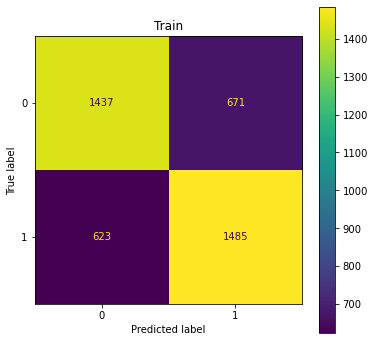

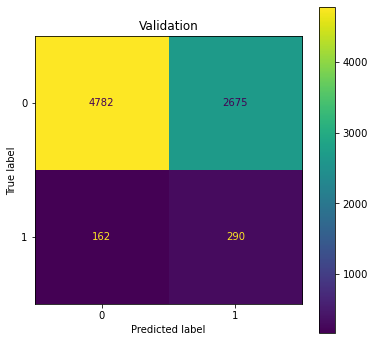

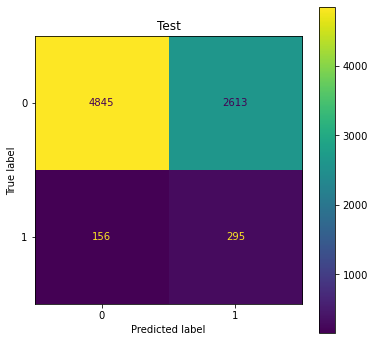

In [56]:
pp_tfidf.fit(X_train_1, y_train_1)

scores(pp_tfidf, X_train_1, y_train_1, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

The scores did not improve very much. In addition, n-grams were slightly more overfitting without this model.

### Model 2: Multinomial Naives Bayes

In [57]:
mnb = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('mnb', MultinomialNB())   
    ])

Train Scores
accuracy:  0.639943074003795
recall:    0.6740986717267552
Validation Scores
accuracy:  0.6003287394107978
recall:    0.6415929203539823
Test Scores
accuracy:  0.6036161335187761
recall:    0.6629711751662971


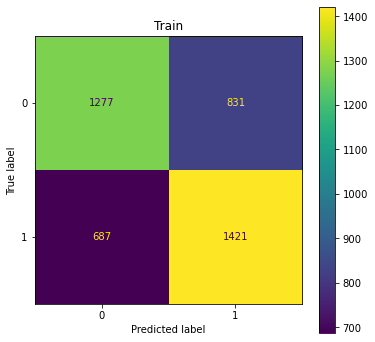

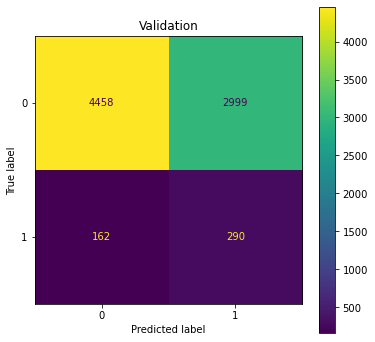

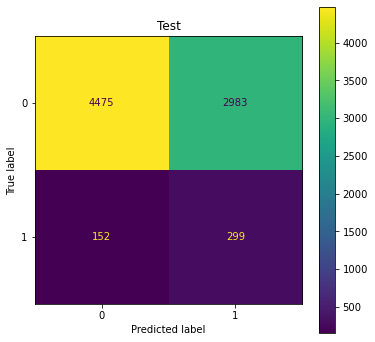

In [58]:
mnb.fit(X_train_1, y_train_1)

scores(mnb, X_train_1, y_train_1, 'Train')
scores(mnb, X_val, y_val, 'Validation')
mnb_acc, mnb_recall = scores(mnb, X_test, y_test, 'Test')

### Model 3: Random Forest

In [59]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('rf', RandomForestClassifier(random_state=42))   
    ])

In [60]:
grid = {'rf__max_depth': [3,5,8,10],
        'rf__max_features': ['auto', 'sqrt'],
        'rf__min_samples_leaf': [2, 5, 10],
        'rf__min_samples_split': [2, 5, 7]}

In [61]:
gs_rf = GridSearchCV(estimator=pp_tfidf, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Train Scores
accuracy:  0.9717741935483871
recall:    0.972011385199241
Validation Scores
accuracy:  0.6421797951700594
recall:    0.6769911504424779
Test Scores
accuracy:  0.6452143128081932
recall:    0.6784922394678492


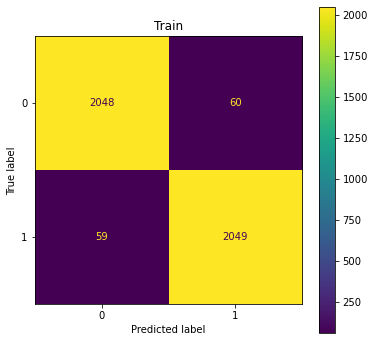

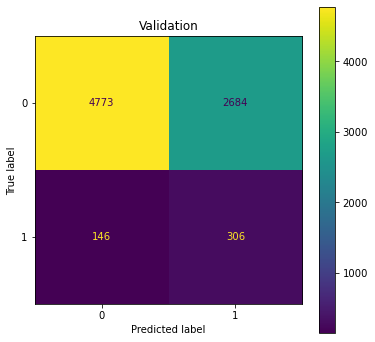

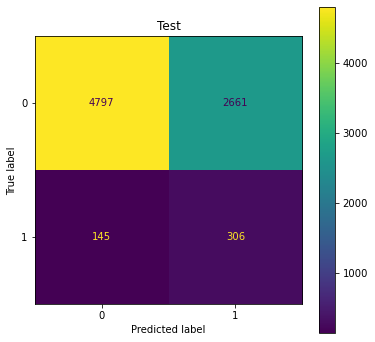

In [62]:
gs_rf.fit(X_train_1, y_train_1)

scores(gs_rf, X_train_1, y_train_1, 'Train')
scores(gs_rf, X_val, y_val, 'Validation')
rf_acc, rf_recall = scores(gs_rf, X_test, y_test, 'Test')

In [63]:
gs_rf.best_params_

{'rf__max_depth': 10,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 2}

In [64]:
"""
{'rf__max_depth': 8,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 5}
"""

"\n{'rf__max_depth': 8,\n 'rf__max_features': 'auto',\n 'rf__min_samples_leaf': 2,\n 'rf__min_samples_split': 5}\n"

### Model 4: K-Nearest Neighbors

In [65]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('knn', KNeighborsClassifier())   
    ])

In [66]:
grid = {'knn__n_neighbors': list(range(3, 10, 2)),
        'knn__weights': ['uniform', 'distance']}

In [67]:
gs_knn = GridSearchCV(estimator=pp_tfidf, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Train Scores
accuracy:  0.6933111954459203
recall:    0.7969639468690702
Validation Scores
accuracy:  0.5106840308509293
recall:    0.7123893805309734
Test Scores
accuracy:  0.5326842837273992
recall:    0.7494456762749445


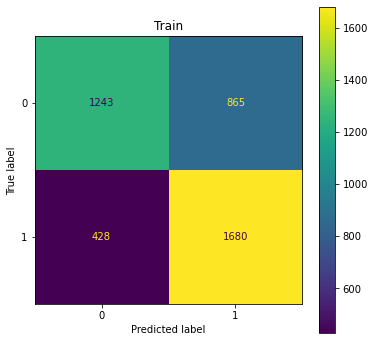

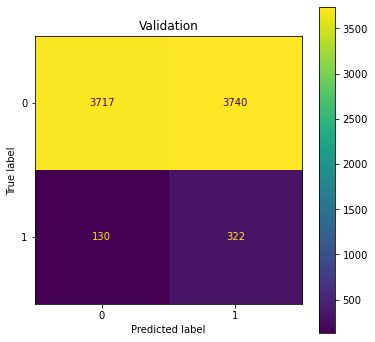

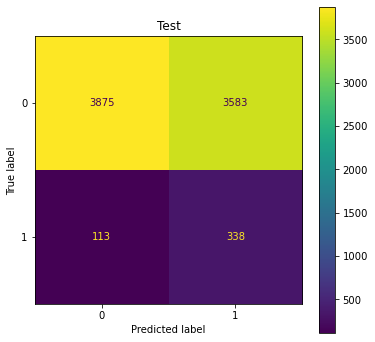

In [68]:
gs_knn.fit(X_train_1, y_train_1)

scores(gs_knn, X_train_1, y_train_1, 'Train')
scores(gs_knn, X_val, y_val, 'Validation')
knn_acc, knn_recall = scores(gs_knn, X_test, y_test, 'Test')

In [69]:
gs_knn.best_params_

{'knn__n_neighbors': 9, 'knn__weights': 'uniform'}

In [70]:
"""
{'knn__n_neighbors': 9, 'knn__weights': 'uniform'}
"""

"\n{'knn__n_neighbors': 9, 'knn__weights': 'uniform'}\n"

### Model 5: Decision Tree Model

In [71]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('dt', DecisionTreeClassifier(random_state=42))   
    ])

In [72]:
grid = {'dt__criterion': ['gini', 'entropy'],
        'dt__max_depth': np.arange(1,16, 5),
        'dt__min_samples_split': np.arange(40, 101, 20),
        'dt__min_samples_leaf': np.arange(40, 101,20)
       }

In [73]:
gs_dt = GridSearchCV(estimator=pp_tfidf, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Train Scores
accuracy:  0.601280834914611
recall:    0.5531309297912713
Validation Scores
accuracy:  0.6354785687191806
recall:    0.5619469026548672
Test Scores
accuracy:  0.6357314451890251
recall:    0.5343680709534369


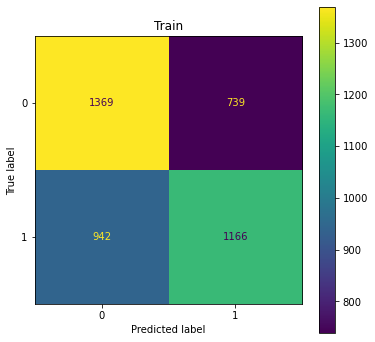

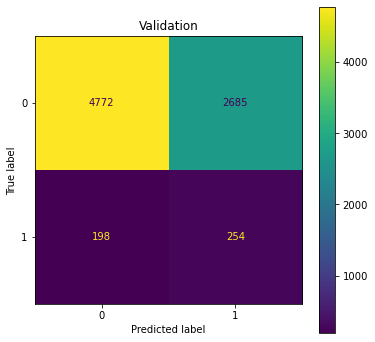

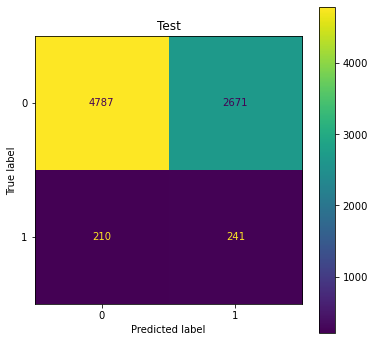

In [74]:
gs_dt.fit(X_train_1, y_train_1)

scores(gs_dt, X_train_1, y_train_1, 'Train')
scores(gs_dt, X_val, y_val, 'Validation')
dt_acc, dt_recall = scores(gs_dt, X_test, y_test, 'Test')

In [75]:
gs_dt.best_params_

{'dt__criterion': 'entropy',
 'dt__max_depth': 1,
 'dt__min_samples_leaf': 40,
 'dt__min_samples_split': 40}

In [76]:
"""
{'dt__criterion': 'entropy',
 'dt__max_depth': 6,
 'dt__min_samples_leaf': 40,
 'dt__min_samples_split': 100
"""

"\n{'dt__criterion': 'entropy',\n 'dt__max_depth': 6,\n 'dt__min_samples_leaf': 40,\n 'dt__min_samples_split': 100\n"

### Model 6: Gradient Boost

In [77]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('gbc', GradientBoostingClassifier(random_state=42))   
    ])

In [78]:
grid = {'gbc__max_features': ['auto','log2'],
        'gbc__min_samples_split':[10, 50, 100, 1000],
        'gbc__max_depth':[3, 5, 10, 20]
       }

In [79]:
gs_gbc = GridSearchCV(estimator=pp_tfidf, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Train Scores
accuracy:  0.7599620493358634
recall:    0.7694497153700189
Validation Scores
accuracy:  0.6457200657478822
recall:    0.6637168141592921
Test Scores
accuracy:  0.650904033379694
recall:    0.6762749445676275


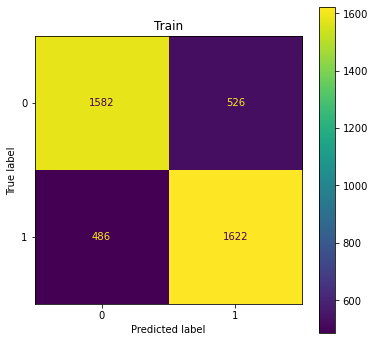

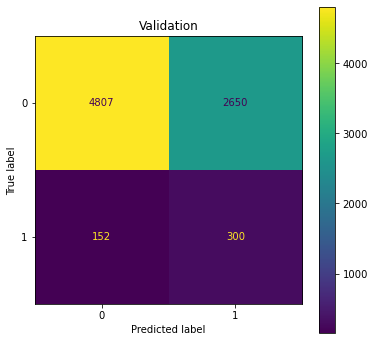

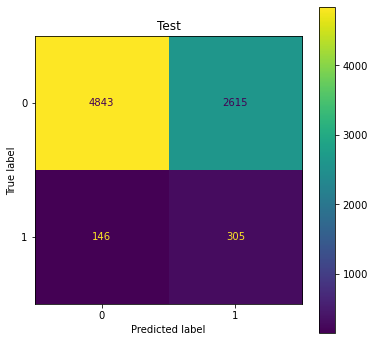

In [80]:
gs_gbc.fit(X_train_1, y_train_1)

scores(gs_gbc, X_train_1, y_train_1, 'Train')
scores(gs_gbc, X_val, y_val, 'Validation')
gbc_acc, gbc_recall = scores(gs_gbc, X_test, y_test, 'Test')

In [81]:
gs_gbc.best_params_

{'gbc__max_depth': 3,
 'gbc__max_features': 'log2',
 'gbc__min_samples_split': 50}

In [82]:
"""
{'gbc__max_depth': 3,
 'gbc__max_features': 'auto',
 'gbc__min_samples_split': 1000
"""

"\n{'gbc__max_depth': 3,\n 'gbc__max_features': 'auto',\n 'gbc__min_samples_split': 1000\n"

### Model 7: Ensemble

In [83]:
mnb = MultinomialNB()

rf = RandomForestClassifier(random_state=42,
                            max_depth= 8,
                            max_features= 'auto',
                            min_samples_leaf= 2,
                            min_samples_split= 5)

knn = KNeighborsClassifier(n_neighbors= 9,
                           weights= 'uniform')

dt = DecisionTreeClassifier(random_state=42,
                            criterion= 'gini',
                            max_depth= 6,
                            min_samples_leaf= 40,
                            min_samples_split= 40)

gb = GradientBoostingClassifier(random_state=42,
                               max_depth= 3,
                                max_features= 'auto',
                                min_samples_split= 1000)

In [84]:
voting_clf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('rf', VotingClassifier(estimators={
                                          ("mnb", mnb),
                                          ("rf", rf),
                                          ('knn', knn),
                                          ('dt', dt),
                                          ("gb", gb)
                                         }, 
                                          voting= "soft"))   
    ])

Train Scores
accuracy:  0.7777514231499051
recall:    0.8078747628083491
Validation Scores
accuracy:  0.6066506511569099
recall:    0.7035398230088495
Test Scores
accuracy:  0.6218232393475787
recall:    0.7006651884700665


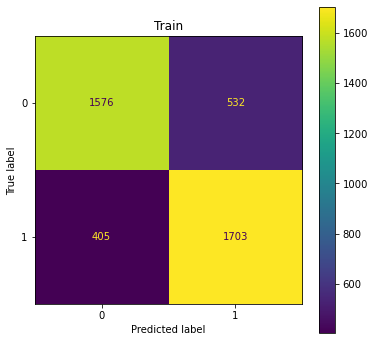

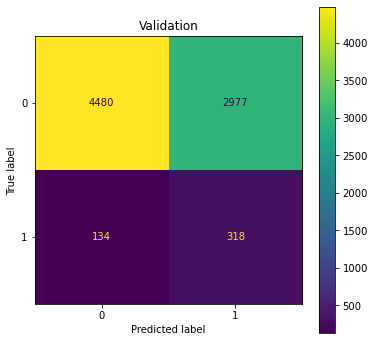

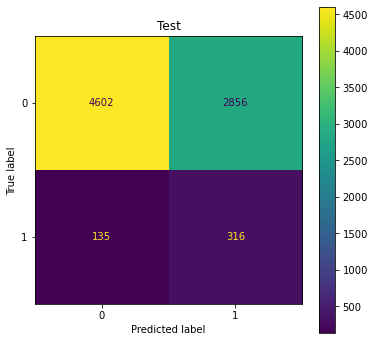

In [85]:
voting_clf.fit(X_train_1, y_train_1)

scores(voting_clf, X_train_1, y_train_1, 'Train')
scores(voting_clf, X_val, y_val, 'Validation')
vot_acc, vot_recall = scores(voting_clf, X_test, y_test, 'Test')

## Reviewing All Models:

In [86]:
X_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7']
y1 = [log_recall, mnb_recall, rf_recall, knn_recall, dt_recall, gbc_recall, vot_recall]

In [87]:
y2 = [log_acc, mnb_acc, rf_acc, knn_acc, dt_acc, gbc_acc, vot_acc]

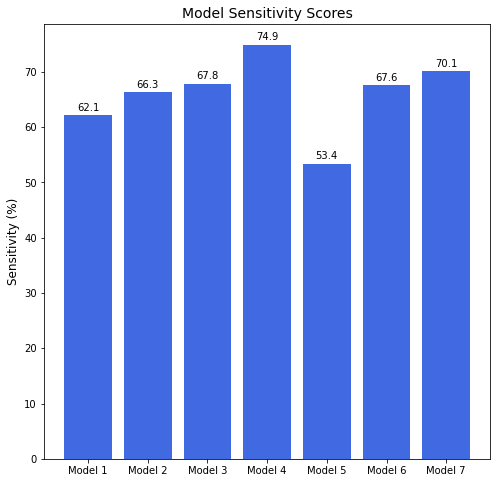

In [88]:
#create a figure
fig, ax = plt.subplots(figsize=(8,8))
#set background color to white
fig.patch.set_facecolor('white')
#create a bar graph
ax.bar(X_labels, y1, color='royalblue')
#set the title and axis label
ax.set_title('Model Sensitivity Scores',fontsize=14)
ax.set_ylabel("Sensitivity (%)", fontsize=12)

#add in total values at the top of each bar
rects = ax.patches
labels = y1
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.5, label, ha="center", va="bottom"
    )

plt.show()

#save the figure in the images folder
fig.savefig('images/Model_Sensitivity_Scores.png', bbox_inches='tight')

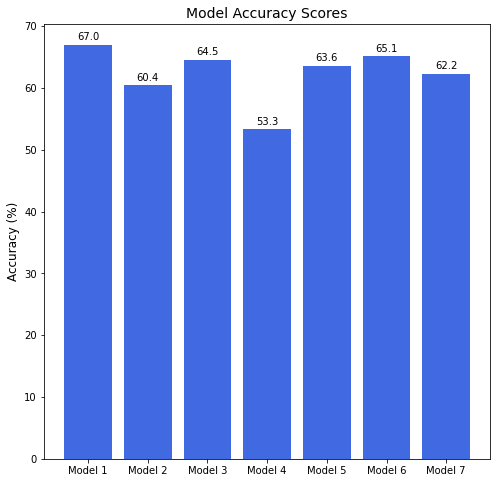

In [89]:
#create a figure
fig, ax = plt.subplots(figsize=(8,8))
#set background color to white
fig.patch.set_facecolor('white')
#create a bar graph
ax.bar(X_labels, y2, color='royalblue')
#set the title and axis label
ax.set_title('Model Accuracy Scores',fontsize=14)
ax.set_ylabel("Accuracy (%)", fontsize=12)

#add in total values at the top of each bar
rects = ax.patches
labels = y2
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.5, label, ha="center", va="bottom"
    )

plt.show()

#save the figure in the images folder
fig.savefig('images/Model_Accuracy_Scores.png', bbox_inches='tight')

In [90]:
#split the positive and negative data
df_pos = df[df['READMISSION']==1]
df_neg = df[df['READMISSION']==0]

In [91]:
#take a sample of the negative training set with the same number of rows as positive dataset
df_neg_samp = df_neg.sample(n=len(df_pos), random_state=42)

In [92]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_df = pd.concat([df_pos,df_neg_samp],axis=0)

In [93]:
#randomize the new dataset
new_df = new_df.sample(n=len(new_df), random_state=42)

In [94]:
#split out the X and y of the new dataset
new_y = new_df['READMISSION']
new_X = new_df['TEXT']
new_max_feats = int(new_X.shape[0]*0.10)

In [95]:
final_model = voting_clf = Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words=sw, max_features=new_max_feats)),
                                           ('rf', VotingClassifier(estimators={("mnb", mnb),
                                                                               ("rf", rf),
                                                                               ('knn', knn),
                                                                               ('dt', dt),
                                                                               ("gb", gb)},
                                                                   voting= "soft"))
                                          ])

Final Scores
accuracy:  0.6546675264575352
recall:    0.7851212221853205


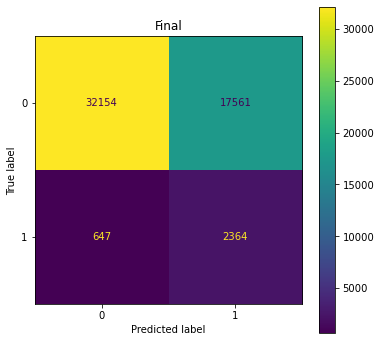

In [96]:
final_model.fit(new_X, new_y)
final_acc, final_recall = scores(final_model, X, y, 'Final')

In [105]:
y_preds = final_model.predict(X)
y_probs = final_model.predict_proba(X)

In [111]:
y_preds = pd.DataFrame(y_preds)
y_probs = pd.DataFrame(y_probs)

In [113]:
y_probs.drop(0, axis=1, inplace=True)

## Merging Results to Other Features and Exporting Data

In [114]:
new_df1 = df.copy()
new_df2 = df.copy()

new_df1 = new_df1.merge(y_preds, left_index=True, right_index=True)
new_df1.drop('TEXT', axis=1, inplace=True)
new_df1.rename(columns={0: 'TEXT'}, inplace=True)
                        
new_df2 = new_df2.merge(y_probs, left_index=True, right_index=True)
new_df2.drop('TEXT', axis=1, inplace=True)
new_df2.rename(columns={1: 'TEXT'}, inplace=True)

In [116]:
#export the modified dataframe with predicted classifications to the data folder
new_df1.to_csv("data/admissions_nlp_processed_1.csv.gz" , index = False,compression='gzip')

In [117]:
#export the modified dataframe with predicted probabilites to the data folder
new_df2.to_csv("data/admissions_nlp_processed_2.csv.gz" , index = False,compression='gzip')